# CNN in Python

Code and notebook written by Eric Reber and Gregor Kajda, \
Center of Computing in Science Education

In this notebook we present flexible and readable python code for a CNN implemented with NumPy. We will present the code, showcase how to use the codebase and fit a CNN that yields a 99% accuracy on the 28x28 MNIST dataset within reasonable time.

The CNN can be used with all schedulers, cost functions and activation functions presented in  https://github.com/EricEReber/Neural-Network/blob/dev/notebook/Neural-Network.ipynb, which we will also showcase in this notebook before the CNN.

The CNN code consists of different types of Layer classes, including Convolution2DLayer, Pooling2DLayer, FlattenLayer, FullyConnectedLayer and OutputLayer, which can be added to the CNN object using the interface of the CNN class. This allows students to easily construct their own CNN, as well as allowing students to get used to an interface similar to that of TensorFlow which is used for real world applications.

Another important feature of this code is that it throws errors if unreasonable decisions are made (for example using a kernel that is larger than the image, not using a FlattenLayer, etc), and provides the user with an informative error message.

## I. Schedulers
The code below shows object oriented implementations of the Constant, Momentum, Adagrad, AdagradMomentum, RMS prop and Adam schedulers. All of the classes belong to the shared abstract Scheduler class, and share the update_change() and reset() methods allowing for any of the schedulers to be seamlessly used during the training stage, as will later be shown in the fit() method of the neural network. Update_change() only has one parameter, the gradient ($\delta^{l}_{j}a^{l-1}_k$), and returns the change which will be subtracted from the weights. The reset() function takes no parameters, and resets the desired variables. For Constant and Momentum, reset does nothing.

In [1]:
import autograd.numpy as np

class Scheduler:
    """
    Abstract class for Schedulers
    """

    def __init__(self, eta):
        self.eta = eta

    # should be overwritten
    def update_change(self, gradient):
        raise NotImplementedError

    # overwritten if needed
    def reset(self):
        pass


class Constant(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)

    def update_change(self, gradient):
        return self.eta * gradient
    
    def reset(self):
        pass


class Momentum(Scheduler):
    def __init__(self, eta: float, momentum: float):
        super().__init__(eta)
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        self.change = self.momentum * self.change + self.eta * gradient
        return self.change

    def reset(self):
        pass


class Adagrad(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)
        self.G_t = None

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = np.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + np.sqrt(np.reshape(np.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        return self.eta * gradient * G_t_inverse

    def reset(self):
        self.G_t = None


class AdagradMomentum(Scheduler):
    def __init__(self, eta, momentum):
        super().__init__(eta)
        self.G_t = None
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = np.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + np.sqrt(np.reshape(np.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        self.change = self.change * self.momentum + self.eta * gradient * G_t_inverse
        return self.change

    def reset(self):
        self.G_t = None


class RMS_prop(Scheduler):
    def __init__(self, eta, rho):
        super().__init__(eta)
        self.rho = rho
        self.second = 0.0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero
        self.second = self.rho * self.second + (1 - self.rho) * gradient * gradient
        return self.eta * gradient / (np.sqrt(self.second + delta))

    def reset(self):
        self.second = 0.0


class Adam(Scheduler):
    def __init__(self, eta, rho, rho2):
        super().__init__(eta)
        self.rho = rho
        self.rho2 = rho2
        self.moment = 0
        self.second = 0
        self.n_epochs = 1

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        self.moment = self.rho * self.moment + (1 - self.rho) * gradient
        self.second = self.rho2 * self.second + (1 - self.rho2) * gradient * gradient

        moment_corrected = self.moment / (1 - self.rho**self.n_epochs)
        second_corrected = self.second / (1 - self.rho2**self.n_epochs)

        return self.eta * moment_corrected / (np.sqrt(second_corrected + delta))

    def reset(self):
        self.n_epochs += 1
        self.moment = 0
        self.second = 0

## Usage of schedulers

To initalize a scheduler, simply create the object and pass in the necessary parameters such as the learning rate and the momentum as shown below. As the Scheduler class is an abstract class it should not called directly, and will raise an error upon usage.


In [2]:
momentum_scheduler = Momentum(eta=1e-3, momentum=0.9)
adam_scheduler = Adam(eta=1e-3, rho=0.9, rho2=0.999)

Here is a small example for how a segment of code using schedulers could look. Switching out the schedulers is simple.

In [3]:
weights = np.ones((3,3))
print(f"Before scheduler:\n{weights=}")

epochs = 10
for e in range(epochs):
    gradient = np.random.rand(3, 3)
    change = adam_scheduler.update_change(gradient)
    weights = weights - change
    adam_scheduler.reset()

print(f"\nAfter scheduler:\n{weights=}")

Before scheduler:
weights=array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

After scheduler:
weights=array([[0.99399317, 0.993993  , 0.993993  ],
       [0.99399301, 0.99399302, 0.99399312],
       [0.99399301, 0.99399301, 0.99399303]])


## II. Cost functions

In this section we will quickly look at cost functions that can be used when creating the neural network. Every cost function takes the target vector as its parameter, and returns a function valued only at X such that it may easily be differentiated.


In [4]:
def CostOLS(target):
    """
    Return OLS function valued only at X, so
    that it may be easily differentiated
    """

    def func(X):
        return (1.0 / target.shape[0]) * np.sum((target - X) ** 2)

    return func


def CostLogReg(target):
    """
    Return Logistic Regression cost function
    valued only at X, so that it may be easily differentiated
    """

    def func(X):
        return -(1.0 / target.shape[0]) * np.sum(
            (target * np.log(X + 10e-10)) + ((1 - target) * np.log(1 - X + 10e-10))
        )

    return func


def CostCrossEntropy(target):
    """
    Return cross entropy cost function valued only at X, so
    that it may be easily differentiated
    """
    
    def func(X):
        return -(1.0 / target.size) * np.sum(target * np.log(X + 10e-10))

    return func


## Usage of cost functions

Below we will provide a short example of how these cost function may be used to obtain results if you wish to test them out on your own using AutoGrad's automatic differentiation.


In [11]:
from autograd import grad

target = np.array([[1, 2, 3]]).T
a = np.array([[4, 5, 6]]).T

cost_func = CostCrossEntropy
cost_func_derivative = grad(cost_func(target))

valued_at_a = cost_func_derivative(a)
print(f"Derivative of cost function {cost_func.__name__} valued at a:\n{valued_at_a}")

Derivative of cost function CostCrossEntropy valued at a:
[[-0.08333333]
 [-0.13333333]
 [-0.16666667]]


## III. Activation functions

Finally, before we look at the layers that make up the neural network, we will look at the activation functions which can be specified between the hidden layers and as the output function. Each function can be valued for any given vector or matrix X, and can be differentiated via derivate().


In [7]:
import autograd.numpy as np
from autograd import elementwise_grad

def identity(X):
    return X


def sigmoid(X):
    try:
        return 1.0 / (1 + np.exp(-X))
    except FloatingPointError:
        return np.where(X > np.zeros(X.shape), np.ones(X.shape), np.zeros(X.shape))


def softmax(X):
    X = X - np.max(X, axis=-1, keepdims=True)
    delta = 10e-10
    return np.exp(X) / (np.sum(np.exp(X), axis=-1, keepdims=True) + delta)


def RELU(X):
    return np.where(X > np.zeros(X.shape), X, np.zeros(X.shape))


def LRELU(X):
    delta = 10e-4
    return np.where(X > np.zeros(X.shape), X, delta * X)


def derivate(func):
    if func.__name__ == "RELU":

        def func(X):
            return np.where(X > 0, 1, 0)

        return func

    elif func.__name__ == "LRELU":

        def func(X):
            delta = 10e-4
            return np.where(X > 0, 1, delta)

        return func

    else:
        return elementwise_grad(func)


## Usage of activation functions

Below is a short demonstration of how to use an activation function. The derivative of the activation function will be important when calculating the output delta term during backpropagation. Note that derivate() can also be used for cost functions for a more generalized approach.


In [12]:
z = np.array([[4, 5, 6]]).T
print(f"Input to activation function:\n{z}")

act_func = sigmoid
a = act_func(z)
print(f"\nOutput from {act_func.__name__} activation function:\n{a}")

act_func_derivative = derivate(act_func)
valued_at_z = act_func_derivative(a)
print(f"\nDerivative of {act_func.__name__} activation function valued at z:\n{valued_at_z}")

Input to activation function:
[[4]
 [5]
 [6]]

Output from sigmoid activation function:
[[0.98201379]
 [0.99330715]
 [0.99752738]]

Derivative of sigmoid activation function valued at z:
[[0.19824029]
 [0.19721923]
 [0.19683648]]


## IV The Layers

Now that we have a good understanding of the components used in the CNN, we will take a look at the various layers used in the CNN, including Convolution2DLayer, Convolution2DLayerOPT (and optimized version of the Convoltuion2DLayer, Pooling2DLayer, FlattenLayer, FullyConnectedLayer and OutputLayer, which can be used to make custom convolutional neural networks.

In [13]:
import math
import autograd.numpy as np
from copy import deepcopy, copy
from autograd import grad
from typing import Callable
from src.activationFunctions import *
from src.Schedulers import *
from src.costFunctions import *

"""
Interface contatining all the layers that will be available for construction of 
a models architecture.
"""

# global variables for index readability
input_index = 0
node_index = 1
bias_index = 1
input_channel_index = 1
feature_maps_index = 1
height_index = 2
width_index = 3
kernel_feature_maps_index = 1
kernel_input_channels_index = 0


class Layer:
    def __init__(self, seed):
        self.seed = seed

    def _feedforward(self):
        raise NotImplementedError

    def _backpropagate(self):
        raise NotImplementedError

    def _reset_weights(self, previous_nodes):
        raise NotImplementedError


class FullyConnectedLayer(Layer):
    # FullyConnectedLayer per default uses LRELU and Adam scheduler
    # with an eta of 0.0001, rho of 0.9 and rho2 of 0.999
    def __init__(
        self,
        nodes: int,
        act_func: Callable = LRELU,
        scheduler: Scheduler = Adam(eta=1e-4, rho=0.9, rho2=0.999),
        seed: int = None,
    ):
        super().__init__(seed)
        self.nodes = nodes
        self.act_func = act_func
        self.scheduler_weight = copy(scheduler)
        self.scheduler_bias = copy(scheduler)

        # initiate matrices for later
        self.weights = None
        self.a_matrix = None
        self.z_matrix = None

    def _feedforward(self, X_batch):
        # calculate z
        self.z_matrix = X_batch @ self.weights

        # calculate a, add bias
        bias = np.ones((X_batch.shape[input_index], 1)) * 0.01
        self.a_matrix = self.act_func(self.z_matrix)
        self.a_matrix = np.hstack([bias, self.a_matrix])

        # return a, the input for feedforward in next layer
        return self.a_matrix

    def _backpropagate(self, weights_next, delta_term_next, a_previous, lam):
        # take the derivative of the activation function
        activation_derivative = derivate(self.act_func)

        # calculate the delta term
        delta_term = (
            weights_next[bias_index:, :] @ delta_term_next.T
        ).T * activation_derivative(self.z_matrix)

        # intitiate matrix to store gradient
        # note that we exclude the bias term, which we will calculate later
        gradient_weights = np.zeros(
            (
                a_previous.shape[input_index],
                a_previous.shape[node_index] - bias_index,
                delta_term.shape[node_index],
            )
        )

        # calculate gradient = delta term * previous a
        for i in range(len(delta_term)):
            gradient_weights[i, :, :] = np.outer(
                a_previous[i, bias_index:], delta_term[i, :]
            )

        # sum the gradient, divide by input_index
        gradient_weights = np.mean(gradient_weights, axis=input_index)
        # for the bias gradient we do not multiply by previous a
        gradient_bias = np.mean(delta_term, axis=input_index).reshape(
            1, delta_term.shape[node_index]
        )

        # regularization term
        gradient_weights += self.weights[bias_index:, :] * lam

        # send gradients into scheduler
        # returns update matrix which will be used to update the weights and bias
        update_matrix = np.vstack(
            [
                self.scheduler_bias.update_change(gradient_bias),
                self.scheduler_weight.update_change(gradient_weights),
            ]
        )

        # update weights
        self.weights -= update_matrix

        # return weights and delta term, input for backpropagation in previous layer
        return self.weights, delta_term

    def _reset_weights(self, previous_nodes):
        # sets seed to remove randomness inbetween runs
        if self.seed is not None:
            np.random.seed(self.seed)

        # add bias, initiate random weights
        bias = 1
        self.weights = np.random.randn(previous_nodes + bias, self.nodes)

        # returns number of nodes, used for reset_weights in next layer
        return self.nodes

    def _reset_scheduler(self):
        # resets scheduler per epoch
        self.scheduler_weight.reset()
        self.scheduler_bias.reset()

    def get_prev_a(self):
        # returns a matrix, used in backpropagation
        return self.a_matrix


class OutputLayer(FullyConnectedLayer):
    def __init__(
        self,
        nodes: int,
        output_func: Callable = LRELU,
        cost_func: Callable = CostCrossEntropy,
        scheduler: Scheduler = Adam(eta=1e-4, rho=0.9, rho2=0.999),
        seed: int = None,
    ):
        super().__init__(nodes, output_func, copy(scheduler), seed)
        self.cost_func = cost_func

        # initiate matrices for later
        self.weights = None
        self.a_matrix = None
        self.z_matrix = None

        # decides if the output layer performs binary or multi-class classification
        self.set_pred_format()

    def _feedforward(self, X_batch: np.ndarray):
        # calculate a, z
        # note that bias is not added as this would create an extra output class
        self.z_matrix = X_batch @ self.weights
        self.a_matrix = self.act_func(self.z_matrix)

        # returns prediction
        return self.a_matrix

    def _backpropagate(self, target, a_previous, lam):
        # note that in the OutputLayer the activation function is the output function
        activation_derivative = derivate(self.act_func)

        # calculate output delta terms
        # for multi-class or binary classification
        if self.pred_format == "Multi-class":
            delta_term = self.a_matrix - target
        else:
            cost_func_derivative = grad(self.cost_func(target))
            delta_term = activation_derivative(self.z_matrix) * cost_func_derivative(
                self.a_matrix
            )

        # intiate matrix that stores gradient
        gradient_weights = np.zeros(
            (
                a_previous.shape[input_index],
                a_previous.shape[node_index] - bias_index,
                delta_term.shape[node_index],
            )
        )

        # calculate gradient = delta term * previous a
        for i in range(len(delta_term)):
            gradient_weights[i, :, :] = np.outer(
                a_previous[i, bias_index:], delta_term[i, :]
            )

        # sum the gradient, divide by input_index
        gradient_weights = np.mean(gradient_weights, axis=input_index)
        # for the bias gradient we do not multiply by previous a
        gradient_bias = np.mean(delta_term, axis=input_index).reshape(
            1, delta_term.shape[node_index]
        )

        # regularization term
        gradient_weights += self.weights[bias_index:, :] * lam

        # send gradients into scheduler
        # returns update matrix which will be used to update the weights and bias
        update_matrix = np.vstack(
            [
                self.scheduler_bias.update_change(gradient_bias),
                self.scheduler_weight.update_change(gradient_weights),
            ]
        )

        # update weights
        self.weights -= update_matrix

        # return weights and delta term, input for backpropagation in previous layer
        return self.weights, delta_term

    def set_pred_format(self):
        # sets prediction format to either regression, binary or multi-class classification
        if self.act_func.__name__ is None or self.act_func.__name__ == "identity":
            self.pred_format = "Regression"
        elif self.act_func.__name__ == "sigmoid" or self.act_func.__name__ == "tanh":
            self.pred_format = "Binary"
        else:
            self.pred_format = "Multi-class"

    def _reset_weights(self, previous_nodes):
        # sets seed to remove randomness inbetween runs
        if self.seed is not None:
            np.random.seed(self.seed)

        # add bias, initiate random weights
        bias = 1
        self.weights = np.random.rand(previous_nodes + bias, self.nodes)

        # returns number of nodes, used for reset_weights in next layer
        return self.nodes

    def _reset_scheduler(self):
        # resets scheduler per epoch
        self.scheduler_weight.reset()
        self.scheduler_bias.reset()

    def get_pred_format(self):
        # returns format of prediction
        return self.pred_format


class Convolution2DLayer(Layer):
    def __init__(
        self,
        input_channels,
        feature_maps,
        kernel_height,
        kernel_width,
        v_stride,
        h_stride,
        pad,
        act_func: Callable,
        seed=None,
        reset_self=True,
    ):
        super().__init__(seed)
        self.input_channels = input_channels
        self.feature_maps = feature_maps
        self.kernel_height = kernel_height
        self.kernel_width = kernel_width
        self.v_stride = v_stride
        self.h_stride = h_stride
        self.pad = pad
        self.act_func = act_func

        # such that the layer can be used on its own
        # outside of the CNN module
        if reset_self == True:
            self._reset_weights_single_layer()

    def _reset_weights_single_layer(self):
        # sets seed to remove randomness inbetween runs
        if self.seed is not None:
            np.random.seed(self.seed)

        # initializes kernel matrix
        self.kernel = np.ndarray(
            (
                self.input_channels,
                self.feature_maps,
                self.kernel_height,
                self.kernel_width,
            )
        )

        # randomly initializes weights
        for chin in range(self.kernel.shape[kernel_input_channels_index]):
            for fmap in range(self.kernel.shape[kernel_feature_maps_index]):
                self.kernel[chin, fmap, :, :] = np.random.rand(
                    self.kernel_height, self.kernel_width
                )

    def _reset_weights(self, previous_nodes):
        # sets weights
        self._reset_weights_single_layer()

        # returns shape of output used for subsequent layer's weight initiation
        strided_height = int(
            np.ceil(previous_nodes.shape[height_index] / self.v_stride)
        )
        strided_width = int(np.ceil(previous_nodes.shape[width_index] / self.h_stride))
        next_nodes = np.ones(
            (
                previous_nodes.shape[input_index],
                self.feature_maps,
                strided_height,
                strided_width,
            )
        )
        return next_nodes / self.kernel_height

    def _feedforward(self, X_batch):
        # note that the shape of X_batch = [batch_size, input_maps, img_height, img_width]

        # pad the input batch
        X_batch_padded = self._padding(X_batch)

        # calculate height_index and width_index after stride
        strided_height = int(np.ceil(X_batch.shape[height_index] / self.v_stride))
        strided_width = int(np.ceil(X_batch.shape[width_index] / self.h_stride))

        # create output array
        output = np.ndarray(
            (
                X_batch.shape[input_index],
                self.feature_maps,
                strided_height,
                strided_width,
            )
        )

        # save input and output for backpropagation
        self.X_batch_feedforward = X_batch
        self.output_shape = output.shape

        # checking for errors, no need to look here :)
        self._check_for_errors()

        # convolve input with kernel
        for img in range(X_batch.shape[input_index]):
            for chin in range(self.input_channels):
                for fmap in range(self.feature_maps):
                    out_h = 0
                    for h in range(0, X_batch.shape[height_index], self.v_stride):
                        out_w = 0
                        for w in range(0, X_batch.shape[width_index], self.h_stride):
                            output[img, fmap, out_h, out_w] = np.sum(
                                X_batch_padded[
                                    img,
                                    chin,
                                    h : h + self.kernel_height,
                                    w : w + self.kernel_width,
                                ]
                                * self.kernel[chin, fmap, :, :]
                            )
                            out_w += 1
                        out_h += 1

        # Pay attention to the fact that we're not rotating the kernel by 180 degrees when filtering the image in
        # the convolutional layer, as convolution in terms of Machine Learning is a procedure known as cross-correlation
        # in image processing and signal processing

        # return a
        return self.act_func(output / (self.kernel_height))

    def _backpropagate(self, delta_term_next):
        # intiate matrices
        delta_term = np.zeros((self.X_batch_feedforward.shape))
        gradient_kernel = np.zeros((self.kernel.shape))

        # pad input for convolution
        X_batch_padded = self._padding(self.X_batch_feedforward)

        # Since an activation function is used at the output of the convolution layer, its derivative
        # has to be accounted for in the backpropagation -> as if ReLU was a layer on its own.
        act_derivative = derivate(self.act_func)
        delta_term_next = act_derivative(delta_term_next)

        if self.v_stride > 1:
            v_ind = 1
            for i in range(delta_term_next.shape[height_index]):
                for j in range(self.v_stride - 1):
                    delta_term_next = np.insert(
                        delta_term_next, v_ind, 0, axis=height_index
                    )
                v_ind += self.v_stride

        if self.h_stride > 1:
            h_ind = 1
            for i in range(delta_term_next.shape[width_index]):
                for k in range(self.h_stride - 1):
                    delta_term_next = np.insert(
                        delta_term_next, v_ind, 0, axis=width_index
                    )
                h_ind += self.h_stride

            # crops out 0-rows and 0-columns
        delta_term_next = delta_term_next[
            :,
            :,
            : self.X_batch_feedforward.shape[height_index],
            : self.X_batch_feedforward.shape[width_index],
        ]

        # The gradient received from the next layer also needs to be padded
        delta_term_next = self._padding(delta_term_next)

        # calculate delta term by convolving next delta term with kernel
        for img in range(self.X_batch_feedforward.shape[input_index]):
            for chin in range(self.input_channels):
                for fmap in range(self.feature_maps):
                    for h in range(self.X_batch_feedforward.shape[height_index]):
                        for w in range(self.X_batch_feedforward.shape[width_index]):
                            delta_term[img, chin, h, w] = np.sum(
                                delta_term_next[
                                    img,
                                    fmap,
                                    h : h + self.kernel_height,
                                    w : w + self.kernel_width,
                                ]
                                * np.rot90(np.rot90(self.kernel[chin, fmap, :, :]))
                            )

        # calculate gradient for kernel for weight update
        # also via convolution
        for chin in range(self.input_channels):
            for fmap in range(self.feature_maps):
                for k_x in range(self.kernel_height):
                    for k_y in range(self.kernel_width):
                        gradient_kernel[chin, fmap, k_x, k_y] = np.sum(
                            X_batch_padded[
                                img,
                                chin,
                                h : h + self.kernel_height,
                                w : w + self.kernel_width,
                            ]
                            * delta_term_next[
                                img,
                                fmap,
                                h : h + self.kernel_height,
                                w : w + self.kernel_width,
                            ]
                        )
        # all kernels are updated with weight gradient of kernel
        self.kernel -= gradient_kernel

        # return delta term
        return delta_term

    def _padding(self, X_batch, batch_type="image"):

        if self.pad == "same" and batch_type == "image":
            padded_height = X_batch.shape[height_index] + (self.kernel_height // 2) * 2
            padded_width = X_batch.shape[width_index] + (self.kernel_width // 2) * 2
            half_kernel_height = self.kernel_height // 2
            half_kernel_width = self.kernel_width // 2

            new_tensor = np.ndarray(
                (
                    X_batch.shape[input_index],
                    X_batch.shape[feature_maps_index],
                    padded_height,
                    padded_width,
                )
            )

            for img in range(X_batch.shape[input_index]):
                padded_img = np.zeros(
                    (X_batch.shape[feature_maps_index], padded_height, padded_width)
                )
                padded_img[
                    :,
                    half_kernel_height : padded_height - half_kernel_height,
                    half_kernel_width : padded_width - half_kernel_width,
                ] = X_batch[img, :, :, :]
                new_tensor[img, :, :, :] = padded_img[:, :, :]

            return new_tensor

        elif self.pad == "same" and batch_type == "grad":
            padded_height = X_batch.shape[height_index] + (self.kernel_height // 2) * 2
            padded_width = X_batch.shape[width_index] + (self.kernel_width // 2) * 2
            half_kernel_height = self.kernel_height // 2
            half_kernel_width = self.kernel_width // 2

            new_tensor = np.zeros(
                (
                    X_batch.shape[input_index],
                    X_batch.shape[feature_maps_index],
                    padded_height,
                    padded_width,
                )
            )

            new_tensor[
                :, :, : X_batch.shape[height_index], : X_batch.shape[width_index]
            ] = X_batch[:, :, :, :]

            return new_tensor

        else:
            return X_batch

    def _check_for_errors(self):
        if self.X_batch_feedforward.shape[input_channel_index] != self.input_channels:
            raise AssertionError(
                f"ERROR: Number of input channels in data ({self.X_batch_feedforward.shape[input_channel_index]}) is not equal to input channels in Convolution2DLayerOPT ({self.input_channels})! Please change the number of input channels of the Convolution2DLayer such that they are equal"
            )


class Convolution2DLayerOPT(Convolution2DLayer):
    """
    Am optimized version of the convolution layer above which 
    utilizes an approach of extracting windows of size equivalent 
    in size to the filter. The convoution is then performed on those 
    windows instead of a full feature map. 
    """
    def __init__(
        self,
        input_channels,
        feature_maps,
        kernel_height,
        kernel_width,
        v_stride,
        h_stride,
        pad,
        act_func: Callable,
        seed=None,
        reset_self=True,
    ):
        super().__init__(
            input_channels,
            feature_maps,
            kernel_height,
            kernel_width,
            v_stride,
            h_stride,
            pad,
            act_func,
            seed,
        )
        if reset_self == True:
            self._reset_weights_single_layer()

    def _extract_windows(self, X_batch, batch_type="image"):
        # TODO: Change padding so that it takes the height_index and width_index of kernel as arguments -> WHY?
        """
        Receives as input the X_batch with shape (batch_size, feature_maps, image_height, image_width) 
        and extract windows of size filter_height * filter_width for every image and every feature_map. 
        It then returns an np.ndarray of shape (image_height * image_width, batch_size, feature_maps, kernel_height, kernel_width) 
        which will be used either to filter the images in feedforward or to calculate the gradient.
        """

        windows = []
        if batch_type == "image":
            # pad the images
            X_batch_padded = self._padding(X_batch, batch_type="image")
            img_height, img_width = X_batch_padded.shape[2:]
            # For each location in the image...
            for h in range(
                0,
                img_height - self.kernel_height + self.kernel_height % 2,
                self.v_stride,
            ):
                for w in range(
                    0,
                    img_width - self.kernel_width + self.kernel_width % 2,
                    self.h_stride,
                ):
                    # ...get an image patch of size [fil_size, fil_size]

                    window = X_batch_padded[
                        :,
                        :,
                        h : h + self.kernel_height,
                        w : w + self.kernel_width,
                    ]
                    windows.append(window)
            return np.stack(windows)


        # In order to be able to perform backprogagation by the method of window extraction, 
        # here is a modified approach to extracting the windows which allow for the necessary 
        # upsampling of the gradient in case the on of the stride parameters is larger than one. 

        if batch_type == "grad":

            # TODO description
            # In the case of one of the stride parameters being odd, we have to take some 
            # extra care in calculating the upsampled size of X_batch. We solve this 
            # by simply flooring the result of dividing stride by 2.
            if self.v_stride < 2 or self.v_stride % 2 == 0:
                v_stride = 0
            else:
                v_stride = int(np.floor(self.v_stride / 2))

            if self.h_stride < 2 or self.h_stride % 2 == 0:
                h_stride = 0
            else:
                h_stride = int(np.floor(self.h_stride / 2))

            upsampled_height = (X_batch.shape[height_index] * self.v_stride) - v_stride

            upsampled_width = (X_batch.shape[width_index] * self.h_stride) - h_stride
            
            # When upsampling, we need to insert rows and columns filled with zeros 
            # into each feature map. How many of those we have to insert is purely 
            # dependant on the value of stride parameter in the vertical and horizontal 
            # direction.
            if self.v_stride > 1:
                v_ind = 1
                for i in range(X_batch.shape[height_index]):
                    for j in range(self.v_stride - 1):
                        X_batch = np.insert(X_batch, ind, 0, axis=height_index)
                    v_ind += self.v_stride

            if self.h_stride > 1:
                h_ind = 1,
                for i in range(X_batch.shape[width_index]):
                    for k in range(self.h_stride - 1):
                        X_batch = np.insert(X_batch, ind, 0, axis=width_index)
                    h_ind += self.h_stride

            # Since the insertion of zero-filled rows and columns isn't perfect, we have 
            # to assure that the resulting feature maps will have the expected upsampled height 
            # and width by cutting them og at desired dimensions. 

            X_batch = X_batch[:, :, :upsampled_height, :upsampled_width]

            X_batch_padded = self._padding(X_batch, batch_type="grad")

            windows = []
            for h in range(
                X_batch_padded.shape[height_index]
                - self.kernel_height
                + self.kernel_height % 2
            ):
                for w in range(
                    X_batch_padded.shape[width_index]
                    - self.kernel_width
                    + self.kernel_width % 2
                ):
                    # ...get an image patch of size [fil_size, fil_size]

                    window = X_batch_padded[
                        :, :, h : h + self.kernel_height, w : w + self.kernel_width
                    ]
                    windows.append(window)

            return np.stack(windows), upsampled_height, upsampled_width

    def _feedforward(self, X_batch):
        # The optimized _feedforward method is difficult to understand but computationally more efficient
        # for a more "by the book" approach, please look at the _feedforward method of Convolution2DLayer

        # save the input for backpropagation
        self.X_batch_feedforward = X_batch

        # check that there are the correct amount of input channels
        self._check_for_errors()

        # calculate new shape after stride
        strided_height = int(np.ceil(X_batch.shape[height_index] / self.v_stride))
        strided_width = int(np.ceil(X_batch.shape[width_index] / self.h_stride))

        # get windows of the image for more computationally efficient convolution
        # the idea is that we want to align the dimensions that we wish to matrix
        # multiply, then use a simple matrix multiplication instead of convolution.
        # then, we reshape the size back to its intended shape
        windows = self._extract_windows(X_batch)
        windows = windows.transpose(1, 0, 2, 3, 4).reshape(
            X_batch.shape[input_index],
            strided_height * strided_width,
            -1,
        )

        # reshape the kernel for more computationally efficient convolution
        kernel = self.kernel
        kernel = kernel.transpose(0, 2, 3, 1).reshape(
            kernel.shape[kernel_input_channels_index]
            * kernel.shape[height_index]
            * kernel.shape[width_index],
            -1,
        )

        # use simple matrix calculation to obtain output
        output = (
            (windows @ kernel)
            .reshape(
                X_batch.shape[input_index],
                strided_height,
                strided_width,
                -1,
            )
            .transpose(0, 3, 1, 2)
        )

        # The output is reshaped and rearranged to appropriate shape
        return self.act_func(
            output / (self.kernel_height * X_batch.shape[feature_maps_index])
        )

    def _backpropagate(self, delta_term_next):
        # The optimized _backpropagate method is difficult to understand but computationally more efficient
        # for a more "by the book" approach, please look at the _backpropagate method of Convolution2DLayer
        act_derivative = derivate(self.act_func)
        delta_term_next = act_derivative(delta_term_next)

        strided_height = int(
            np.ceil(self.X_batch_feedforward.shape[height_index] / self.v_stride)
        )
        strided_width = int(
            np.ceil(self.X_batch_feedforward.shape[width_index] / self.h_stride)
        )

        kernel = self.kernel

        windows = self._extract_windows(self.X_batch_feedforward, "image").reshape(
            self.X_batch_feedforward.shape[input_index]
            * strided_height
            * strided_width,
            -1,
        )

        output_grad_tr = delta_term_next.transpose(0, 2, 3, 1).reshape(
            self.X_batch_feedforward.shape[input_index]
            * strided_height
            * strided_width,
            -1,
        )

        gradient_kernel = (
            (windows.T @ output_grad_tr)
            .reshape(
                kernel.shape[kernel_input_channels_index],
                kernel.shape[height_index],
                kernel.shape[width_index],
                kernel.shape[kernel_feature_maps_index],
            )
            .transpose(0, 3, 1, 2)
        )
        
        # computing the input gradient
        windows_out, upsampled_height, upsampled_width = self._extract_windows(
            delta_term_next, "grad"
        )

        new_windows_first_dim = (
            self.X_batch_feedforward.shape[input_index]
            * upsampled_height
            * upsampled_width
        )
        new_windows_sec_dim = int(np.ceil(windows_out.size / new_windows_first_dim))

        windows_out = windows_out.transpose(1, 0, 2, 3, 4).reshape(
            new_windows_first_dim, new_windows_sec_dim
        )

        kernel_reshaped = kernel.reshape(self.input_channels, -1)

        input_grad = (windows_out @ kernel_reshaped.T).reshape(
            self.X_batch_feedforward.shape[input_index],
            upsampled_height,
            upsampled_width,
            kernel.shape[kernel_input_channels_index],
        )
        input_grad = input_grad.transpose(0, 3, 1, 2)

        # Update the weights in the kernel
        self.kernel -= gradient_kernel

        # Output the gradient to propagate backwards
        return input_grad

    def _check_for_errors(self):
        # compares input channels of data to input channels of Convolution2DLayer
        if self.X_batch_feedforward.shape[input_channel_index] != self.input_channels:
            raise AssertionError(
                f"ERROR: Number of input channels in data ({self.X_batch_feedforward.shape[input_channel_index]}) is not equal to input channels in Convolution2DLayerOPT ({self.input_channels})! Please change the number of input channels of the Convolution2DLayer such that they are equal"
            )


class Pooling2DLayer(Layer):
    def __init__(
        self,
        kernel_height,
        kernel_width,
        v_stride,
        h_stride,
        pooling="max",
        seed=None,
    ):
        super().__init__(seed)
        self.kernel_height = kernel_height
        self.kernel_width = kernel_width
        self.v_stride = v_stride
        self.h_stride = h_stride
        self.pooling = pooling

    def _feedforward(self, X_batch):
        # Saving the input for use in the backwardpass
        self.X_batch_feedforward = X_batch

        # check if user is silly
        self._check_for_errors()

        # Computing the size of the feature maps based on kernel size and the stride parameter
        strided_height = (
            X_batch.shape[height_index] - self.kernel_height
        ) // self.v_stride + 1
        if X_batch.shape[height_index] == X_batch.shape[width_index]:
            strided_width = strided_height
        else:
            strided_width = (
                X_batch.shape[width_index] - self.kernel_width
            ) // self.h_stride + 1

        # initialize output array
        output = np.ndarray(
            (
                X_batch.shape[input_index],
                X_batch.shape[feature_maps_index],
                strided_height,
                strided_width,
            )
        )

        # select pooling action, either max or average pooling
        if self.pooling == "max":
            self.pooling_action = np.max
        elif self.pooling == "average":
            self.pooling_action = np.mean

        # pool based on kernel size and stride
        for img in range(output.shape[input_index]):
            for fmap in range(output.shape[feature_maps_index]):
                for h in range(strided_height):
                    for w in range(strided_width):
                        output[img, fmap, h, w] = self.pooling_action(
                            X_batch[
                                img,
                                fmap,
                                (h * self.v_stride) : (h * self.v_stride)
                                + self.kernel_height,
                                (w * self.h_stride) : (w * self.h_stride)
                                + self.kernel_width,
                            ]
                        )

        # output for feedforward in next layer
        return output

    def _backpropagate(self, delta_term_next):
        # initiate delta term array
        delta_term = np.zeros((self.X_batch_feedforward.shape))

        for img in range(delta_term_next.shape[input_index]):
            for fmap in range(delta_term_next.shape[feature_maps_index]):
                for x in range(0, delta_term_next.shape[height_index], self.v_stride):
                    for y in range(
                        0, delta_term_next.shape[width_index], self.h_stride
                    ):
                        # max pooling
                        if self.pooling == "max":
                            window = self.X_batch_feedforward[
                                img,
                                fmap,
                                x : x + self.kernel_height,
                                y : y + self.kernel_width,
                            ]

                            # TODO window_h and window_w?
                            i, j = np.unravel_index(window.argmax(), window.shape)

                            delta_term[
                                img,
                                fmap,
                                (x + i),
                                (y + j),
                            ] += delta_term_next[img, fmap, x, y]

                        # average pooling
                        if self.pooling == "average":
                            delta_term[
                                img,
                                fmap,
                                x : x + self.kernel_height,
                                y : y + self.kernel_width,
                            ] = (
                                delta_term_next[img, fmap, h, w]
                                / self.kernel_height
                                / self.kernel_width
                            )
        # returns input to backpropagation in previous layer
        return delta_term

    def _reset_weights(self, previous_nodes):
        # calculate strided height, strided width
        strided_height = (
            previous_nodes.shape[height_index] - self.kernel_height
        ) // self.v_stride + 1
        if previous_nodes.shape[height_index] == previous_nodes.shape[width_index]:
            strided_width = strided_height
        else:
            strided_width = (
                previous_nodes.shape[width_index] - self.kernel_width
            ) // self.h_stride + 1

        # initiate output array
        output = np.ones(
            (
                previous_nodes.shape[input_index],
                previous_nodes.shape[feature_maps_index],
                strided_height,
                strided_width,
            )
        )

        # returns output with shape used for reset weights in next layer
        return output

    def _check_for_errors(self):
        # check if input is smaller than kernel size -> error
        assert (
            self.X_batch_feedforward.shape[width_index] >= self.kernel_width
        ), f"ERROR: Pooling kernel width_index ({self.kernel_width}) larger than data width_index ({self.X_batch_feedforward.input.shape[2]}), please lower the kernel width_index of the Pooling2DLayer"
        assert (
            self.X_batch_feedforward.shape[height_index] >= self.kernel_height
        ), f"ERROR: Pooling kernel height_index ({self.kernel_height}) larger than data height_index ({self.X_batch_feedforward.input.shape[3]}), please lower the kernel height_index of the Pooling2DLayer"


class FlattenLayer(Layer):
    def __init__(self, act_func=LRELU, seed=None):
        super().__init__(seed)
        self.act_func = act_func

    def _feedforward(self, X_batch):
        # save input for backpropagation
        self.X_batch_feedforward_shape = X_batch.shape
        # Remember, the data has the following shape: (B, FM, H, W, ) in the convolutional layers
        # whilst the data has the shape (B, FM * H * W) in the fully connected layers
        # FM = Feature maps, B = Batch size, H = Height and W = Width
        X_batch = X_batch.reshape(
            X_batch.shape[input_index],
            X_batch.shape[feature_maps_index]
            * X_batch.shape[height_index]
            * X_batch.shape[width_index],
        )

        # add bias to a
        self.z_matrix = X_batch
        bias = np.ones((X_batch.shape[input_index], 1)) * 0.01
        self.a_matrix = np.hstack([bias, X_batch])

        # return a, the input to feedforward in next layer
        return self.a_matrix

    def _backpropagate(self, weights_next, delta_term_next):
        activation_derivative = derivate(self.act_func)

        # calculate delta term
        delta_term = (
            weights_next[bias_index:, :] @ delta_term_next.T
        ).T * activation_derivative(self.z_matrix)

        # FlattenLayer does not update weights
        # reshapes delta layer to convolutional layer data format [Input, Feature_Maps, Height, Width]
        return delta_term.reshape(self.X_batch_feedforward_shape)

    def get_prev_a(self):
        return self.a_matrix

    def _reset_weights(self, previous_nodes):
        # note that the previous nodes to the FlattenLayer are from the convolutional layers
        previous_nodes = previous_nodes.reshape(
            previous_nodes.shape[input_index],
            previous_nodes.shape[feature_maps_index]
            * previous_nodes.shape[height_index]
            * previous_nodes.shape[width_index],
        )

        # return shape used in reset_weights in next layer
        return previous_nodes.shape[node_index]


## Usage of layers

The layers will usually be used within the CNN class rather than on their own. If one wishes to construct a regular feed forward neural network using these layers, it would have to start from the FlattenLayer due to technical details regarding the weight initiation.

For Convolution2DLayer, we have specifically implemented a weight initiation such that it can be used on its own such that we can better visualize convolution.

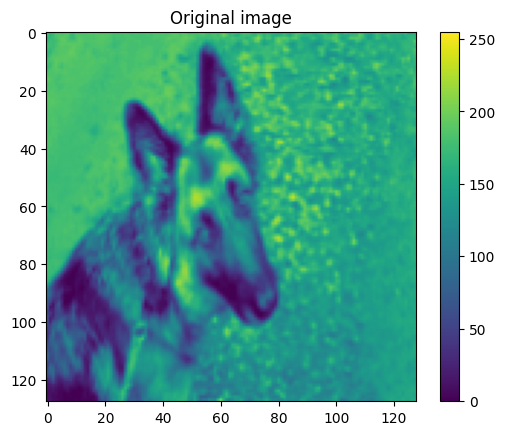

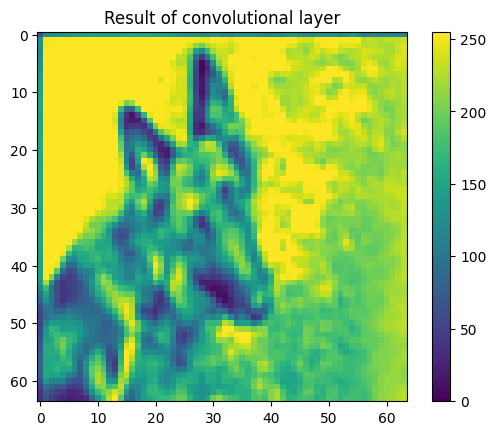

In [50]:
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt

def plot_convolution_result(X, layer):
    plt.imshow(X[0, 0, :, :], vmin=0, vmax=255)
    plt.title("Original image")
    plt.colorbar()
    plt.show()
    conv_result = layer._feedforward(X)
    plt.title("Result of convolutional layer")
    plt.imshow(conv_result[0, 0, :, :], vmin=0, vmax=255)
    plt.colorbar()
    plt.show()

# create layer
layer = Convolution2DLayerOPT(
    input_channels=3,
    feature_maps=1,
    kernel_height=4,
    kernel_width=4,
    v_stride=2,
    h_stride=2,
    pad="same",
    act_func=identity,
    seed=2023,
    )

# read in image path, make data correct format
img_path = "../data/luna.JPG"
image_of_cute_dog = imageio.imread(img_path)
image_shape = image_of_cute_dog.shape
image_of_cute_dog = image_of_cute_dog.reshape(1, image_shape[0], image_shape[1], image_shape[2])
image_of_cute_dog = image_of_cute_dog.transpose(0, 3, 1, 2)

# plot the result of the convolution
plot_convolution_result(image_of_cute_dog, layer)


From the images, you can see that the result has half the pixels on each axis due to the fact that we've used a horizontal and vertical stride of 2. We can also see that the convolutional layer has to some degree seperated the dog from the background, which will be useful later for the classifier.

Note that image data usually comes in many different shapes and sizes, but for our CNN we require the input data be formatted as \[Number of inputs, input channels, input height, input width\]. Occasionally, the data you come accross use will be formatted like this, but on many occasions reshaping and transposing the dimensions is sadly necessary.

## The Convolutional Neural Network (CNN)

Finally, we will present the code for the CNN. The CNN class organizes all the layers, and allows for training on image data.

In [51]:
import math
import autograd.numpy as np
import sys
import warnings
from src.Schedulers import *
from src.activationFunctions import *
from src.costFunctions import *
from src.Layers import *
from autograd import grad, elementwise_grad
from random import random, seed
from copy import deepcopy
from typing import Tuple, Callable
from sklearn.utils import resample
from collections import OrderedDict


warnings.simplefilter("error")


class CNN:
    def __init__(
        self,
        cost_func: Callable = CostCrossEntropy,
        scheduler: Scheduler = Adam(eta=1e-4, rho=0.9, rho2=0.999),
        seed: int = None,
    ):
        """
        Description:
        ------------
            Instantiates CNN object

        Parameters:
        ------------
            I   output_func (costFunctions) cost function for feed forward neural network part of CNN,
                such as "CostLogReg", "CostOLS" or "CostCrossEntropy"

            II  scheduler (Scheduler) optional parameter, default set to Adam. Can also be set to other
                schedulers such as AdaGrad, Momentum, RMS_prop and Constant. Note that schedulers have
                to be instantiated first with proper parameters (for example eta, rho and rho2 for Adam)

            III seed (int) used for seeding all random operations
        """
        self.layers = list()
        self.cost_func = cost_func
        self.scheduler = scheduler
        self.schedulers_weight = list()
        self.schedulers_bias = list()
        self.seed = seed
        self.pred_format = None

    def add_FullyConnectedLayer(
        self, nodes: int, act_func=LRELU, scheduler=None
    ) -> None:
        """
        Description:
        ------------
            Add a FullyConnectedLayer to the CNN, i.e. a hidden layer in the feed forward neural
            network part of the CNN. Often called a Dense layer in literature

        Parameters:
        ------------
            I   nodes (int) number of nodes in FullyConnectedLayer
            II  act_func (activationFunctions) activation function of FullyConnectedLayer,
                such as "sigmoid", "RELU", "LRELU", "softmax" or "identity"
            III scheduler (Scheduler) optional parameter, default set to Adam. Can also be set to other
                schedulers such as AdaGrad, Momentum, RMS_prop and Constant
        """
        assert self.layers, "FullyConnectedLayer should follow FlattenLayer in CNN"

        if scheduler is None:
            scheduler = self.scheduler

        layer = FullyConnectedLayer(nodes, act_func, scheduler, self.seed)
        self.layers.append(layer)

    def add_OutputLayer(self, nodes: int, output_func=sigmoid, scheduler=None) -> None:
        """
        Description:
        ------------
            Add an OutputLayer to the CNN, i.e. a the final layer in the feed forward neural
            network part of the CNN

        Parameters:
        ------------
            I   nodes (int) number of nodes in OutputLayer. Set nodes=1 for binary classification and
                nodes = number of classes for multi-class classification
            II  output_func (activationFunctions) activation function for the output layer, such as
                "identity" for regression, "sigmoid" for binary classification and "softmax" for multi-class
                classification
            III scheduler (Scheduler) optional parameter, default set to Adam. Can also be set to other
                schedulers such as AdaGrad, Momentum, RMS_prop and Constant
        """
        assert self.layers, "OutputLayer should follow FullyConnectedLayer in CNN"

        if scheduler is None:
            scheduler = self.scheduler

        output_layer = OutputLayer(
            nodes, output_func, self.cost_func, scheduler, self.seed
        )
        self.layers.append(output_layer)
        self.pred_format = output_layer.get_pred_format()

    def add_FlattenLayer(self, act_func=LRELU) -> None:
        """
        Description:
        ------------
            Add a FlattenLayer to the CNN, which flattens the image data such that it is formatted to
            be used in the feed forward neural network part of the CNN
        """
        self.layers.append(FlattenLayer(act_func=act_func, seed=self.seed))

    def add_Convolution2DLayer(
        self,
        input_channels=1,
        feature_maps=3,
        kernel_height=32,
        kernel_width=32,
        v_stride=1,
        h_stride=1,
        pad="same",
        act_func=LRELU,
        optimized=True,
    ) -> None:
        """
        Description:
        ------------
            Add a Convolution2DLayer to the CNN, i.e. a convolutional layer with a 2 dimensional kernel. Should be
            the first layer added to the CNN

        Parameters:
        ------------
            I   input_channels (int) specifies amount of input channels. For monochrome images, use input_channels
                = 1, and input_channels = 3 for colored images, where each channel represents one of R, G and B
            II  feature_maps (int) amount of feature maps in CNN
            III kernel_height (int) height of the kernel, also called 'convolutional filter' in literature
            IV  kernel_width (int) width of the kernel, also called 'convolutional filter' in literature
            V   v_stride (int) value of vertical stride for dimentionality reduction
            VI  h_stride (int) value of horizontal stride for dimentionality reduction
            VII pad (str) default = "same" ensures output size is the same as input size (given stride=1)
           VIII act_func (activationFunctions) default = "LRELU", nonlinear activation function
             IX optimized (bool) default = True, uses Convolution2DLayerOPT if True which is much faster when
                compared to Convolution2DLayer, which is a more straightforward, understandable implementation
        """
        if optimized:
            conv_layer = Convolution2DLayerOPT(
                input_channels,
                feature_maps,
                kernel_height,
                kernel_width,
                v_stride,
                h_stride,
                pad,
                act_func,
                self.seed,
                reset_self=False,
            )
        else:
            conv_layer = Convolution2DLayer(
                input_channels,
                feature_maps,
                kernel_height,
                kernel_width,
                v_stride,
                h_stride,
                pad,
                act_func,
                self.seed,
                reset_self=False,
            )
        self.layers.append(conv_layer)

    def add_PoolingLayer(
        self, kernel_height=2, kernel_width=2, v_stride=1, h_stride=1, pooling="max"
    ) -> None:
        """
        Description:
        ------------
            Add a Pooling2DLayer to the CNN, i.e. a pooling layer that reduces the dimentionality of
            the image data. It is not necessary to use a Pooling2DLayer when creating a CNN, but it
            can be used to speed up the training

        Parameters:
        ------------
            I   kernel_height (int) height of the kernel used for pooling
            II  kernel_width (int) width of the kernel used for pooling
            III v_stride (int) value of vertical stride for dimentionality reduction
            IV  h_stride (int) value of horizontal stride for dimentionality reduction
            V   pooling (str) either "max" or "average", describes type of pooling performed
        """
        pooling_layer = Pooling2DLayer(
            kernel_height, kernel_width, v_stride, h_stride, pooling, self.seed
        )
        self.layers.append(pooling_layer)

    def fit(
        self,
        X: np.ndarray,
        t: np.ndarray,
        epochs: int = 100,
        lam: float = 0,
        batches: int = 1,
        X_val: np.ndarray = None,
        t_val: np.ndarray = None,
    ) -> dict:
        """
        Description:
        ------------
            Fits the CNN to input X for a given amount of epochs. Performs feedforward and backpropagation passes,
            can utilize batches, regulariziation and validation if desired.

        Parameters:
        ------------
            X (numpy array) with input data in format [images, input channels,
            image height, image_width]
            t (numpy array) target labels for input data
            epochs (int) amount of epochs
            lam (float) regulariziation term lambda
            batches (int) amount of batches input data splits into
            X_val (numpy array) validation data
            t_val (numpy array) target labels for validation data

        Returns:
        ------------
            scores (dict) a dictionary with "train_error", "train_acc", "val_error", val_acc" keys
            that contain numpy arrays with float values of all accuracies/errors over all epochs.
            Can be used to create plots. Also used to update the progress bar during training
        """

        # setup
        if self.seed is not None:
            np.random.seed(self.seed)

        # initialize weights
        self._initialize_weights(X)

        # create arrays for score metrics
        scores = self._initialize_scores(epochs)

        assert batches <= t.shape[0]
        batch_size = X.shape[0] // batches

        try:
            for epoch in range(epochs):
                for batch in range(batches):
                    # minibatch gradient descent
                    # If the for loop has reached the last batch, take all thats left
                    if batch == batches - 1:
                        X_batch = X[batch * batch_size :, :, :, :]
                        t_batch = t[batch * batch_size :, :]
                    else:
                        X_batch = X[
                            batch * batch_size : (batch + 1) * batch_size, :, :, :
                        ]
                        t_batch = t[batch * batch_size : (batch + 1) * batch_size, :]

                    self._feedforward(X_batch)
                    self._backpropagate(t_batch, lam)

                # reset schedulers for each epoch (some schedulers pass in this call)
                for layer in self.layers:
                    if isinstance(layer, FullyConnectedLayer):
                        layer._reset_scheduler()

                # computing performance metrics
                scores = self._compute_scores(scores, epoch, X, t, X_val, t_val)

                # printing progress bar
                print_length = self._progress_bar(
                    epoch,
                    epochs,
                    scores,
                )
        # allows for stopping training at any point and seeing the result
        except KeyboardInterrupt:
            pass

        # visualization of training progression (similiar to tensorflow progression bar)
        sys.stdout.write("\r" + " " * print_length)
        sys.stdout.flush()
        self._progress_bar(
            epochs,
            epochs,
            scores,
        )
        sys.stdout.write("")

        return scores

    def _feedforward(self, X_batch) -> np.ndarray:
        """
        Description:
        ------------
            Performs the feedforward pass for all layers in the CNN. Called from fit()
        """
        a = X_batch
        for layer in self.layers:
            a = layer._feedforward(a)

        return a

    def _backpropagate(self, t_batch, lam) -> None:
        """
        Description:
        ------------
            Performs backpropagation for all layers in the CNN. Called from fit()
        """
        assert len(self.layers) >= 2
        reversed_layers = self.layers[::-1]

        # for every layer, backwards
        for i in range(len(reversed_layers) - 1):
            layer = reversed_layers[i]
            prev_layer = reversed_layers[i + 1]

            # OutputLayer
            if isinstance(layer, OutputLayer):
                prev_a = prev_layer.get_prev_a()
                weights_next, delta_next = layer._backpropagate(t_batch, prev_a, lam)

            # FullyConnectedLayer
            elif isinstance(layer, FullyConnectedLayer):
                assert (
                    delta_next is not None
                ), "No OutputLayer to follow FullyConnectedLayer"
                assert (
                    weights_next is not None
                ), "No OutputLayer to follow FullyConnectedLayer"
                prev_a = prev_layer.get_prev_a()
                weights_next, delta_next = layer._backpropagate(
                    weights_next, delta_next, prev_a, lam
                )

            # FlattenLayer
            elif isinstance(layer, FlattenLayer):
                assert (
                    delta_next is not None
                ), "No FullyConnectedLayer to follow FlattenLayer"
                assert (
                    weights_next is not None
                ), "No FullyConnectedLayer to follow FlattenLayer"
                delta_next = layer._backpropagate(weights_next, delta_next)

            # Convolution2DLayer and Convolution2DLayerOPT
            elif isinstance(layer, Convolution2DLayer):
                assert (
                    delta_next is not None
                ), "No FlattenLayer to follow Convolution2DLayer"
                delta_next = layer._backpropagate(delta_next)

            # Pooling2DLayer
            elif isinstance(layer, Pooling2DLayer):
                assert delta_next is not None, "No Layer to follow Pooling2DLayer"
                delta_next = layer._backpropagate(delta_next)

            # Catch error
            else:
                raise NotImplementedError

    def _compute_scores(
        self,
        scores: dict,
        epoch: int,
        X: np.ndarray,
        t: np.ndarray,
        X_val: np.ndarray,
        t_val: np.ndarray,
    ) -> dict:
        """
        Description:
        ------------
            Computes scores such as training error, training accuracy, validation error
            and validation accuracy for the CNN depending on if a validation set is used
            and if the CNN performs classification or regression

        Returns:
        ------------
            scores (dict) a dictionary with "train_error", "train_acc", "val_error", val_acc" keys
            that contain numpy arrays with float values of all accuracies/errors over all epochs.
            Can be used to create plots. Also used to update the progress bar during training
        """

        pred_train = self.predict(X)
        cost_function_train = self.cost_func(t)
        train_error = cost_function_train(pred_train)
        scores["train_error"][epoch] = train_error

        if X_val is not None and t_val is not None:
            cost_function_val = self.cost_func(t_val)
            pred_val = self.predict(X_val)
            val_error = cost_function_val(pred_val)
            scores["val_error"][epoch] = val_error

        if self.pred_format != "Regression":
            train_acc = self._accuracy(pred_train, t)
            scores["train_acc"][epoch] = train_acc
            if X_val is not None and t_val is not None:
                val_acc = self._accuracy(pred_val, t_val)
                scores["val_acc"][epoch] = val_acc

        return scores

    def _initialize_scores(self, epochs) -> dict:
        """
        Description:
        ------------
            Initializes scores such as training error, training accuracy, validation error
            and validation accuracy for the CNN

        Returns:
        ------------
            A dictionary with "train_error", "train_acc", "val_error", val_acc" keys that
            will contain numpy arrays with float values of all accuracies/errors over all epochs
            when passed through the _compute_scores() function during fit()
        """
        scores = dict()

        train_errors = np.empty(epochs)
        train_errors.fill(np.nan)
        val_errors = np.empty(epochs)
        val_errors.fill(np.nan)

        train_accs = np.empty(epochs)
        train_accs.fill(np.nan)
        val_accs = np.empty(epochs)
        val_accs.fill(np.nan)

        scores["train_error"] = train_errors
        scores["val_error"] = val_errors
        scores["train_acc"] = train_accs
        scores["val_acc"] = val_accs

        return scores

    def _initialize_weights(self, X: np.ndarray) -> None:
        """
        Description:
        ------------
            Initializes weights for all layers in CNN

        Parameters:
        ------------
            I   X (np.ndarray) input of format [img, feature_maps, height, width]
        """
        prev_nodes = X
        for layer in self.layers:
            prev_nodes = layer._reset_weights(prev_nodes)

    def predict(self, X: np.ndarray, *, threshold=0.5) -> np.ndarray:
        """
        Description:
        ------------
            Predicts output of input X

        Parameters:
        ------------
            I   X (np.ndarray) input [img, feature_maps, height, width]
        """

        prediction = self._feedforward(X)

        if self.pred_format == "Binary":
            return np.where(prediction > threshold, 1, 0)
        elif self.pred_format == "Multi-class":
            class_prediction = np.zeros(prediction.shape)
            for i in range(prediction.shape[0]):
                class_prediction[i, np.argmax(prediction[i, :])] = 1
            return class_prediction
        else:
            return prediction

    def _accuracy(self, prediction: np.ndarray, target: np.ndarray) -> float:
        """
        Description:
        ------------
            Calculates accuracy of given prediction to target

        Parameters:
        ------------
            I   prediction (np.ndarray): output of predict() fuction
            (1s and 0s in case of classification, and real numbers in case of regression)
            II  target (np.ndarray): vector of true values (What the network should predict)

        Returns:
        ------------
            A floating point number representing the percentage of correctly classified instances.
        """
        assert prediction.size == target.size
        return np.average((target == prediction))

    def _progress_bar(self, epoch: int, epochs: int, scores: dict) -> int:
        """
        Description:
        ------------
            Displays progress of training
        """
        progression = epoch / epochs
        epoch -= 1
        print_length = 40
        num_equals = int(progression * print_length)
        num_not = print_length - num_equals
        arrow = ">" if num_equals > 0 else ""
        bar = "[" + "=" * (num_equals - 1) + arrow + "-" * num_not + "]"
        perc_print = self._fmt(progression * 100, N=5)
        line = f"  {bar} {perc_print}% "

        for key, score in scores.items():
            if np.isnan(score[epoch]) == False:
                value = self._fmt(score[epoch], N=4)
                line += f"| {key}: {value} "
        print(line, end="\r")
        return len(line)

    def _fmt(self, value: int, N=4) -> str:
        """
        Description:
        ------------
            Formats decimal numbers for progress bar
        """
        if value > 0:
            v = value
        elif value < 0:
            v = -10 * value
        else:
            v = 1
        n = 1 + math.floor(math.log10(v))
        if n >= N - 1:
            return str(round(value))
            # or overflow
        return f"{value:.{N-n-1}f}"
